Download complete.
Extraction complete.
CSV file loaded successfully.
Step 0, MSE: 53991.5976
Step 1000, MSE: 10075.9128
Step 2000, MSE: 8449.6029
Step 3000, MSE: 8154.8182
Step 4000, MSE: 8085.0295
Step 5000, MSE: 8063.3335
Step 6000, MSE: 8055.0065
Step 7000, MSE: 8051.3818
Step 8000, MSE: 8049.6946
Step 9000, MSE: 8048.8786
Step 10000, MSE: 8048.4734
Step 11000, MSE: 8048.2675
Step 12000, MSE: 8048.1605
Step 13000, MSE: 8048.1035
Step 14000, MSE: 8048.0724
Step 15000, MSE: 8048.0549
Step 16000, MSE: 8048.0447
Step 17000, MSE: 8048.0385
Step 18000, MSE: 8048.0345
Step 19000, MSE: 8048.0317

Final Results:
Training MSE: 8048.029717872313
Testing MSE: 18321.093377298694


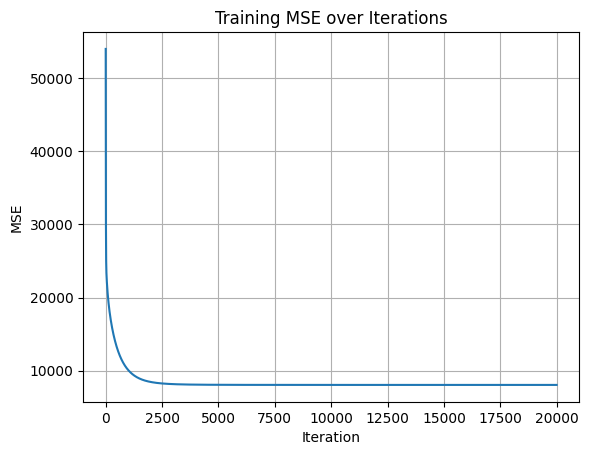

In [2]:
import os
import urllib.request
import zipfile
import csv
import numpy as np
import matplotlib.pyplot as plt

# -------------------- USER PARAMETERS --------------------
DATA_DIR = "Bike_data_input"
ZIP_NAME = "bike_data_zip_file.zip"
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

α = 0.01
Iteration = 20000
training_ratio = 0.75

# -------------------- DOWNLOAD FUNCTION --------------------
def download_bike_sharing_data():
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    zip_path = os.path.join(DATA_DIR, ZIP_NAME)
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(DATA_URL, zip_path)
        print("Download complete.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Extraction complete.")

# -------------------- LOAD CSV --------------------
def load_hour_csv():
    with open(os.path.join(DATA_DIR, 'hour.csv'), 'r') as f:
        reader = csv.reader(f)
        header_name = next(reader)
        data = [row for row in reader]
    print("CSV file loaded successfully.")
    return header_name, data

# -------------------- FEATURE SCALING --------------------
def normalize(X):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    return (X - X_min) / (X_max - X_min + 1e-8)

# -------------------- MSE FUNCTION --------------------
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# -------------------- GRADIENT DESCENT --------------------
def linear_regression_gradient_descent(X, y, α, Iteration):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    error = []
    for i in range(Iteration):
        y_pred = np.dot(X, weights) + bias
        dw = -(2/n_samples) * np.dot(X.T, (y - y_pred))
        db = -(2/n_samples) * np.sum(y - y_pred)
        weights -= α * dw
        bias -= α * db
        mse = mean_squared_error(y, y_pred)
        error.append(mse)
        if i % 1000 == 0:
            print(f"Step {i}, MSE: {mse:.4f}")
    return weights, bias, error

# -------------------- MAIN PIPELINE --------------------
download_bike_sharing_data()
header_name, data = load_hour_csv()

data = np.array(data)
y = data[:, -1].astype(float)  # target cnt
X_raw = data[:, 2:-1]          # all features except instant, dteday, cnt

# Correct categorical indices
cat_idx = [0,1,2,3,5,7]  # season, yr, mnth, hr, weekday, weathersit
num_idx = [i for i in range(X_raw.shape[1]) if i not in cat_idx and i < 12]  # numeric features excluding casual/registered

# Numeric features
X_num = X_raw[:, num_idx].astype(float)

# One-hot encode categorical features
X_cat = []
for idx in cat_idx:
    unique_vals = list(set(X_raw[:, idx]))
    one_hot = np.zeros((X_raw.shape[0], len(unique_vals)))
    for i, val in enumerate(X_raw[:, idx]):
        one_hot[i, unique_vals.index(val)] = 1
    X_cat.append(one_hot)
X_cat = np.concatenate(X_cat, axis=1)

# Combine numeric + categorical features
X = np.concatenate((X_num, X_cat), axis=1)
X = normalize(X)

# Split data: 75% train, 25% test
split_idx = int(training_ratio * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train model
weights, bias, error = linear_regression_gradient_descent(X_train, y_train, α, Iteration)

# Predict
y_train_pred = np.dot(X_train, weights) + bias
y_test_pred = np.dot(X_test, weights) + bias

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nFinal Results:")
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

# Plot training error
plt.plot(error)
plt.title("Training MSE over Iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()
